# Analysis of Ct and iSNVs in Washington dataset.

This notebook explores the relationship between Ct and iSNVs for SCAN and WA-DoH primers. Its purpose is to identify Ct cutoffs for SCAN and WA-DoH primers.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import matplotlib.dates as mdates


In [2]:
def load_snvs(file):
    with open(file) as jfile:
        snvs = json.load(jfile)
    return snvs

snvs = load_snvs('../results/snvs.json')

In [3]:
def load_metadata(file):
    '''
    Loads metadata tsv as df.
    '''
    with open(file) as tfile:
        metadata = pd.read_csv(tfile, sep = '\t')
        metadata['date'] = pd.to_datetime(metadata['date'])
        metadata['nwgc_id'] = metadata['nwgc_id'].astype('str')
        metadata.loc[metadata.origin == 'sfs', 'primers'] = 'scan'
        metadata = metadata.dropna(subset=['avg_ct', 'primers'])
    return metadata

metadata = load_metadata('../results/metadata.tsv')

In [4]:
metadata

,origin,batch,nwgc_id,strain,age_bin,avg_ct,n1_ct,n2_ct,rp_ct,age,...,ct_orf1ab,primers,date,location,country_exposure,region_exposure,division_exposure,puma,address_identifier,symptom_onset
0,sfs,20200229_fastq,385186,USA/WA2/2020,NaN,22.411000,NaN,NaN,NaN,17.00,...,NaN,scan,2020-02-24,Snohomish County,USA,North America,Washington,5311704.0,NaN,NaN
1,sfs,20200304_fastq2,385597,USA/WA-S2/2020,NaN,20.721000,NaN,NaN,NaN,75.00,...,NaN,scan,NaT,NaN,NaN,NaN,NaN,5311602.0,8fd6de5b5273f02be0d5913fa8454b866e80dd490fab4a...,NaN
2,sfs,20200306_fastq,386137,USA/WA-S3/2020,NaN,18.543305,NaN,NaN,NaN,18.00,...,NaN,scan,2020-02-28,NaN,USA,North America,Washington,5311603.0,NaN,NaN
3,sfs,20200320_fastq,386696,USA/WA-S4/2020,NaN,28.006647,NaN,NaN,NaN,55.00,...,NaN,scan,2020-03-01,King County,USA,North America,Washington,5311606.0,59785a39707e69ae5a88c68890291ecd6da22650a06652...,NaN
4,sfs,20200320_fastq,386767,USA/WA-S5/2020,NaN,24.433075,NaN,NaN,NaN,46.75,...,NaN,scan,2020-02-29,King County,USA,North America,Washington,5311601.0,2b9a01410d9028df31d2bf4df81fc64da6050056bc546d...,2020-02-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,wadoh,20200710_fastq,432470,USA/WA-S2704/2020,41-45,23.100000,NaN,NaN,NaN,NaN,...,23.8644,n_gene,2020-06-22,Yakima County,USA,North America,Washington,NaN,NaN,NaN
2704,wadoh,20200710_fastq,432471,USA/WA-S2705/2020,21-25,17.230000,NaN,NaN,NaN,NaN,...,19.0168,n_gene,2020-06-22,Yakima County,USA,North America,Washington,NaN,NaN,NaN
2705,wadoh,20200710_fastq,432472,USA/WA-S2706/2020,46-50,16.460000,NaN,NaN,NaN,NaN,...,16.5365,n_gene,2020-06-23,Yakima County,USA,North America,Washington,NaN,NaN,NaN
2706,wadoh,20200710_fastq,432473,USA/WA-S2707/2020,6-10,12.290000,NaN,NaN,NaN,NaN,...,13.6760,n_gene,2020-06-22,Yakima County,USA,North America,Washington,NaN,NaN,NaN


## Summary of primers and Ct
First off, we have 3 different primers used in our dataset. What is the distribution of those primers across time?

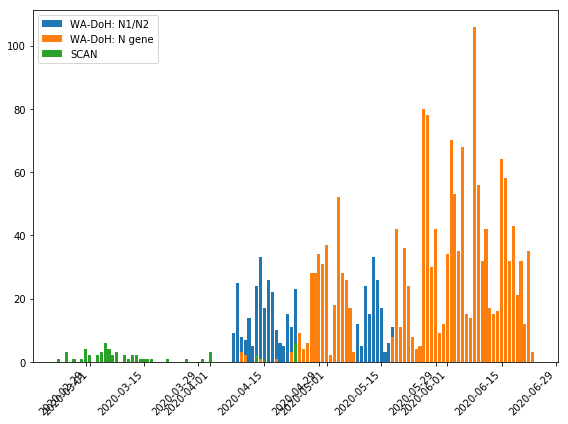

In [5]:
 def plot_primers_time(df):
    fig, ax = plt.subplots(figsize=(8,6))
    df = df.dropna(subset=['primers'])
    for primer in sorted(set(df['primers'])):
        counts = df.loc[df.primers == primer, 'date'].value_counts()
        ax.bar(x = counts.index, height = counts)
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    plt.legend(labels = {'WA-DoH: N1/N2':'n1/n2', 'WA-DoH: N gene':'n_gene', 'SCAN':'scan'})
    ax.xaxis_date()
    plt.draw()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    fig.tight_layout()
    return plt.show()

plot_primers_time(metadata)

What is the Ct distribution for each primer set?

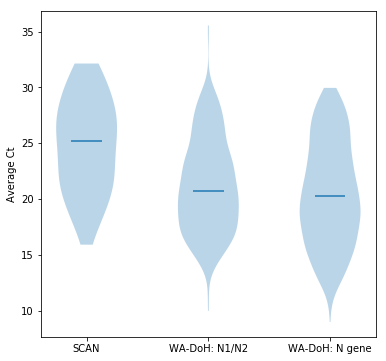

In [19]:
def plot_ct(df):
    primers =  [primer for primer in set(df['primers'])]
    ct = [sorted(df.loc[df.primers == primer, 'avg_ct']) for primer in primers]
    labels_dict = {'n1/n2' : 'WA-DoH: N1/N2', 'n_gene' : 'WA-DoH: N gene', 'scan': 'SCAN'}
    labels = [labels_dict[primer] for primer in primers]
    pos = [i for i in range(3)]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.violinplot(ct, pos, showmedians=True, showextrema = False)
    
    ax.set_ylabel('Average Ct')
    ax.set_xticks(pos)
    ax.set_xticklabels(labels)
    return plt.show()

plot_ct(metadata)

In [8]:
stats.mannwhitneyu(metadata.loc[(metadata.primers=='n1/n2'), 'avg_ct'], metadata.loc[metadata.primers=='n_gene', 'avg_ct'])

MannwhitneyuResult(statistic=346333.0, pvalue=0.0017671640613329369)

So, with WA-DoH primers, Ct's are likely NOT pulled from the same distribution

## Plotting SNVs vs. Ct

In [18]:
def construct_snvs_df(snvs, metadata):
    frequencies = []
    samples = []
    for sample in snvs.keys():
        f = snvs[sample]['frequency']
        frequencies.extend(f)
        samples.extend([sample]*len(f))
    df = pd.DataFrame()
    df['nwgc_id'] = samples
    df['freq'] = frequencies
    df = df.merge(metadata[['avg_ct', 'nwgc_id', 'origin', 'primers']], how = 'left', on='nwgc_id')
    df = df.dropna(subset=['avg_ct', 'primers'])
    return df

snvs_df = construct_snvs_df(snvs, metadata)

In [11]:
def plot_snvs_sample(df):
    titles = {'n1/n2' : 'WA-DoH: N1/N2 samples', 'n_gene' : 'WA-DoH: N gene samples', 'scan': 'SCAN samples'}
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,10))
    for ax, primer in zip([ax1, ax2, ax3], sorted(set(df['primers']))):
        df2 = df[df['primers'] == primer]
        df2 = df2.sort_values(by=['avg_ct'])
        x = df2['nwgc_id']
        y = df2['freq']
        im = ax.scatter(x, y, s = 10, c=df2['avg_ct'], vmin=min(df['avg_ct']), vmax= max(df['avg_ct']), cmap = plt.get_cmap('viridis'))
        ax.set_ylabel('Frequency of iSNVs')
        ax.set_xlabel(titles[primer])
        ax.set_xticks([])
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Average Ct')
    return plt.show()

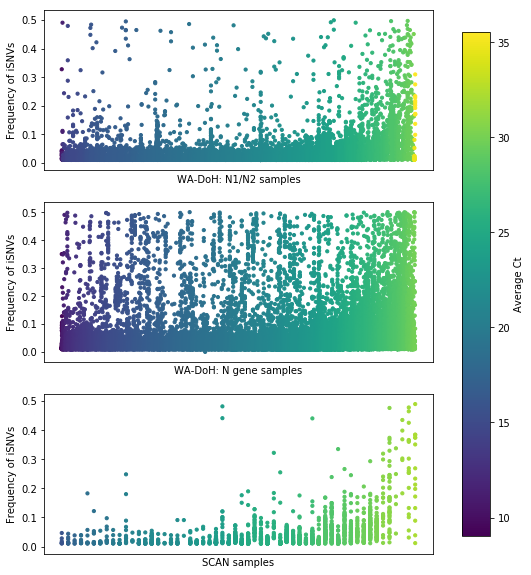

In [13]:
plot_snvs_sample(snvs_df)

In [20]:
def construct_samples_df(snvs, metadata):
    samples = [key for key in snvs.keys()]
    avg_freq = []
    std_freq = []
    total = []
    for sample in samples:
        f = np.mean(snvs[sample]['frequency'])
        avg_freq.append(f)
        std = np.std(snvs[sample]['frequency'])
        std_freq.append(std)
        v = len(snvs[sample]['position'])
        total.append(v)
    df = pd.DataFrame()
    df['nwgc_id'] = samples
    df['avg_freq'] = avg_freq
    df['std'] = std_freq
    df['snvs'] = total
    metadata['nwgc_id'] = metadata.nwgc_id.astype('str')
    df = df.merge(metadata[['avg_ct', 'nwgc_id', 'origin', 'primers']], how = 'left', on='nwgc_id')
    df = df.dropna(subset=['avg_ct', 'primers'])
    df = df.sort_values(by=['avg_ct'])
    return df
samples_df = construct_samples_df(snvs, metadata)

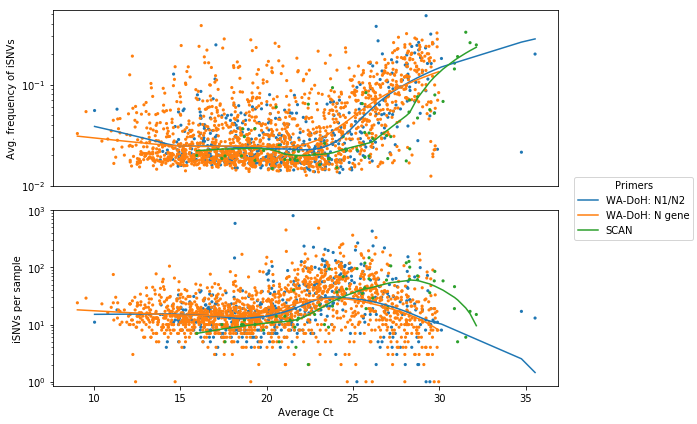

In [16]:
def plot_ct_snvs(df):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(8,6))
    for primer in sorted(set(df['primers'])):
        x = df.loc[df.primers == primer, 'avg_ct']
        y1 = df.loc[df.primers == primer, 'avg_freq']
        y2 = df.loc[df.primers == primer, 'snvs']
        ax1.scatter(x, y1, label = primer, edgecolors = 'none', s=10)
        ax2.scatter(x, y2, label = '', edgecolors = 'none', s=10)
        lowess1 = lowess(y1, x, is_sorted=True, frac=0.4)
        lowess2 = lowess(y2, x, is_sorted=True, frac=0.4)
        ax1.plot(lowess1[:,0], lowess1[:,1])
        ax2.plot(lowess2[:,0], lowess2[:,1])
        
    for ax in [ax1, ax2]:
        #ax.axvline(x=22, c= 'black', lw=0.7)
        #ax.axvline(x=28, c='black', lw=0.7)
        #ax.axvline(x=26, c='black', lw=0.7, ls = '--')
        #ax.axvline(x=21, c='black', lw=0.7, ls = '--')
        ax.set_yscale('log')
        
    ax1.set_ylim(bottom=0.01, top = 0.55)
    ax2.set_ylim(bottom=0.85, top = 1000)
    ax1.set_xticks([])
    ax1.set_ylabel('Avg. frequency of iSNVs')
    ax2.set_xlabel('Average Ct')
    ax2.set_ylabel('iSNVs per sample')
    fig.legend(title = 'Primers', loc = 'center', bbox_to_anchor=(1.1, 0.5), 
               labels = {'WA-DoH: N1/N2':'n1/n2', 'WA-DoH: N gene':'n_gene', 'SCAN':'scan'})
    fig.tight_layout()
    return plt.show()

plot_ct_snvs(samples_df)